<a id='part1'></a>
# Seismological Use Case: EUrythmics
---

---

*This use case shows how to combine the information coming from **5** web services (ws) developped at EMSC for EPOS in order to increase the knowledge from scratch after an earthquake strike.*

---

** Description -- after a strong earthquake occured - and, as an EU scientist - I would like: **
   * know all the relevant information available from EMSC.
   * recover all seismological data and data products available at EMSC for the dedicated earthquake. 

---

*Retrieve the informations as follow:*

[Web Service [1]](#sec_01) - Search for an earthquake (**i.e.** *Fdsn-Event* ws)
   * [[1.1]](#sec_01-1) Get origin parameters
   * [[1.2]](#sec_01-2) Add origins and/or arrivals 
   
[Web Service [2]](#sec_02) - Retrieve the Flinn Endghal region name (**i.e.** *Flinn-Engdhal* ws) 

[Web Service [3]](#sec_03) - Collect Moment Tensors (**i.e.** *Moment Tensor* ws)

[Web Service [4]](#sec_04) - Collect Felt reports (**i.e.** *Testimonies* ws)

[Web Service [5]](#sec_05) - Identify if more informations are available from other seismological institutes (**i.e.** *EventID* ws)

---

The [Seismic Portal](http://www.seismicportal.eu/) is the main interactive gateway to access web services.

| Web Service     | URL                     
| ---             | ---                       
| *FDSN-Event*    | http://www.seismicportal.eu/fdsn-wsevent.html
| *Flinn-Engdhal* | http://www.seismicportal.eu/feregions.html
| *EventID*       | http://vigogne.emsc-csem.org/eventid/
| *Moment Tensor* | http://vigogne.emsc-csem.org/mtws/
| *Testimonies*   | http://vigogne.emsc-csem.org/testimonies-ws/

[EMSC](https://www.emsc-csem.org) is the European Infrastructure for Seismological Products in EPOS. 

In [1]:
# -------------------------------------
# Main functions used in the EUrythmics
# -------------------------------------
#
# Func-Download
import requests
def geturl(url):
    res = requests.get(url, timeout=15)
    return {'status': res.status_code,
            'content': res.text}
#
# Func-Parse (txt)
import csv
from io import StringIO
def parsecsv(txt, usedict=False):
    if usedict:
        parser = csv.DictReader(StringIO(txt), delimiter='|')
    else:
        parser = csv.reader(StringIO(txt), delimiter='|')        
    return [line for line in parser]
#
# Func-Parse (json)
import json
def parsejson(txt):
    return json.loads(txt)
#
# Func-Parse (xml)
from obspy import read_events
def parsexml(url):
   return read_events(url)
# ===================================

<a id='sec_01'></a>
## 1. Search for an earthquake (i.e. Fdsn-Event ws)
---

### The only information you know is that the earthquake you are looking for is contained within a time slot

... search an event between September 1st, 2017 and the end of October with a magnitude greater than 6.5:

> http://www.seismicportal.eu/fdsnws/event/1/query?start=2017-09-01&end=2017-11-01&format=text&minmag=6.5

### Some parameters are known about the earthquake

... the quake sought is the M7.1 Puebla, Mexico on September, 19th 2017:

> | **Unid**       | 20170919_0000091          |
  | **Date time**  | 2017-09-19 18:14:38.5 UTC |
  | **Region**     | PUEBLA, MEXICO            |

<a id='sec_01-1'></a>
### 1.1 Get origin parameters
---

The easiest way to get the parameters of the main origin is to use the *FDSN-Event* web service and to choose the **text** format.

In [2]:
main_event = {'unid':'20170919_0000091'}

In [3]:
%%capture orig

# Download and parse (txt)
url = "http://www.seismicportal.eu/fdsnws/event/1/query?eventid={unid}&format=text".format(unid=main_event['unid'])
res = geturl(url)
dataev = parsecsv(res['content'])
print("---parse-txt---\n{0}\n".format(dataev))

# Download and parse (json)
url = "http://www.seismicportal.eu/fdsnws/event/1/query?eventid={unid}&format=json".format(unid=main_event['unid'])
res = geturl(url)
dataev = parsejson(res['content'])
eqinfo = dataev['properties']
print("---parse-json---\n{0}\n".format(eqinfo))

# Download and parse (xml)
url = "http://www.seismicportal.eu/fdsnws/event/1/query?eventid={unid}&format=xml".format(unid=main_event['unid'])
dataev = parsexml(url)
print("---parse-xml---\n{0}".format(dataev))

In [4]:
%%capture --no-stdout
orig()

---parse-txt---
[['#EventID ', ' Time ', ' Latitude ', ' Longitude ', ' Depth/km ', ' Author ', ' Catalog ', ' Contributor ', ' ContributorID ', ' MagType ', ' Magnitude ', ' MagAuthor ', ' EventLocationName'], ['20170919_0000091', '2017-09-19T18:14:38.5Z', '18.59', '-98.47', '50.0', 'EMSC', 'EMSC-RTS', 'EMSC', '619258', 'mw', '7.1', 'EMSC', 'PUEBLA, MEXICO']]

---parse-json---
{u'lastupdate': u'2017-09-19T18:42:00.0Z', u'magtype': u'mw', u'time': u'2017-09-19T18:14:38.5Z', u'lon': -98.47, u'auth': u'EMSC', u'source_id': u'619258', u'depth': 50.0, u'unid': u'20170919_0000091', u'mag': 7.1, u'evtype': u'ke', u'lat': 18.59, u'source_catalog': u'EMSC-RTS', u'flynn_region': u'PUEBLA, MEXICO'}

---parse-xml---
1 Event(s) in Catalog:
2017-09-19T18:14:38.500000Z | +18.590,  -98.470 | 7.1 mw | manual


<a id='sec_01-2'></a>
### 1.2 Add origins and/or arrivals
---

The *Fdsn-Event* specifications define the parameter:
 * **includeallorigins** (in order to include **all** *origins*)
 * **includearrivals** (to include *arrivals*).
 
Note that in both case, these information are not included with the **text** format option and it is a good choice to use the **QuakeML** format.

**includeallorigins:**

In [5]:
%%capture --no-stdout

#avoid warnings
print "\n*** With origins"
url = "http://www.seismicportal.eu/fdsnws/event/1/query\
?eventid={unid}&format=xml&includeallorigins=true".format(unid=main_event['unid'])
dataev = read_events(url)
print dataev
for ev in dataev:
    print ev


*** With origins
1 Event(s) in Catalog:
2017-09-19T18:14:38.500000Z | +18.590,  -98.470 | 7.1 mw | manual
Event:	2017-09-19T18:14:38.500000Z | +18.590,  -98.470 | 7.1 mw | manual

	            resource_id: ResourceIdentifier(id="quakeml:eu.emsc/event/20170919_0000091")
	          creation_info: CreationInfo(agency_uri=ResourceIdentifier(id="smi:smi-registry/organization/EMSC"), author_uri=ResourceIdentifier(id="smi:smi-registry/organization/EMSC"), creation_time=UTCDateTime(2017, 9, 19, 18, 43, 15, 714461))
	    preferred_origin_id: ResourceIdentifier(id="quakeml:eu.emsc/event/20170919_0000091/origin/FWDO5")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:eu.emsc/event/20170919_0000091/origin/FWDO5/mag/1")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 35 Elements
	             magnitudes: 35 Elements


**includearrivals:**

In [6]:
%%capture --no-stdout

print "\n*** With origins and arrivals"

url = "http://www.seismicportal.eu/fdsnws/event/1/query\
?eventid={unid}&format=xml&includeallorigins=true&includearrivals=true".format(unid=main_event['unid'])
dataev = read_events(url)

print dataev
for ev in dataev:
    print ev


*** With origins and arrivals
1 Event(s) in Catalog:
2017-09-19T18:14:38.500000Z | +18.590,  -98.470 | 7.1 mw | manual
Event:	2017-09-19T18:14:38.500000Z | +18.590,  -98.470 | 7.1 mw | manual

	            resource_id: ResourceIdentifier(id="quakeml:eu.emsc/event/20170919_0000091")
	          creation_info: CreationInfo(agency_uri=ResourceIdentifier(id="smi:smi-registry/organization/EMSC"), author_uri=ResourceIdentifier(id="smi:smi-registry/organization/EMSC"), creation_time=UTCDateTime(2017, 9, 19, 18, 43, 15, 714461))
	    preferred_origin_id: ResourceIdentifier(id="quakeml:eu.emsc/event/20170919_0000091/origin/FWDO5")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:eu.emsc/event/20170919_0000091/origin/FWDO5/mag/1")
	                   ---------
	     event_descriptions: 1 Elements
	                  picks: 560 Elements
	             amplitudes: 560 Elements
	                origins: 35 Elements
	             magnitudes: 35 Elements
	     station_magnitudes: 364 Elements


<a id='sec_02'></a>
## 2. Retrieve the Flinn-Endghal region name (i.e. Flinn-Engdhal ws)
---
This web service returns the Flinn-Endghal region name from a geographical location (longitude and latitude) as input:

In [7]:
url = "http://www.seismicportal.eu/fe_regions_ws/query?format=json&lat={lat}&lon={lon}"
res = geturl(url.format(**eqinfo))
print parsejson(res['content'])

{u'name_s': u'PUEBLA, MEXICO', u'name_h': u'NORTH AMERICA;MEXICO;PUEBLA', u'name_l': u'Puebla, Mexico', u'name_m': u'PUEBLA, MEXICO'}


<a id='sec_03'></a>
## 3. Collect Moment Tensors (i.e. Moment Tensor ws)
---
Find all *moment tensors* data for the M7.1 seismic event in Mexico:

In [8]:
%%capture --no-stdout

url = "http://vigogne.emsc-csem.org/mtws/api/search?format=text&eventid={unid}"
res = geturl(url.format(unid=main_event['unid']))
print res['content'][:1000]

#ev_unid|ev_region|ev_event_time|ev_latitude|ev_longitude|ev_mag_type|ev_mag_value|ev_depth|mt_source_catalog|mt_region|mt_centroid_time|mt_latitude|mt_longitude|mt_mw|mt_depth|mt_strike_1|mt_dip_1|mt_rake_1|mt_strike_2|mt_dip_2|mt_rake_2|mt_tval|mt_tplung|mt_taz|mt_pval|mt_pplung|mt_paz|mt_nval|mt_nplung|mt_naz|mt_mrr|mt_mtt|mt_mpp|mt_mrt|mt_mrp|mt_mtp|mt_per_dc|mt_per_clvd|mt_per_iso|mt_m0
20170919_0000091|PUEBLA, MEXICO|2017-09-19 18:14:38.5 UTC|18.59|-98.47|mw|7.1|50|GCMT|PUEBLA, MEXICO|2017-09-19 18:14:47.1 UTC|18.51|-98.62|7.1|53|108|44|-98|300|47|-82|6.276e19|1|23|-6.506e19|84|281|0.231e19|5|114|-6.43e19|5.28e19|1.15e19|-0.006e19|-0.742e19|-2.25e19|92.91|7.09|0|6.39e19
20170919_0000091|PUEBLA, MEXICO|2017-09-19 18:14:38.5 UTC|18.59|-98.47|mw|7.1|50|CPPT|PUEBLA, MEXICO|2017-09-19 18:14:40 UTC|18.42|-98.57|7|15|324|50|-42|83|59|-132|4.02e19|5|201|-4.019e19|54|299|0e19|35|108|-2.618e19|3.111e19|-0.493e19|-1.254e19|-1.533e19|-1.961e19|99.98|0.02|0|4.02e19
20170919_0000091|PUEBLA, ME

In [9]:
%%capture --no-stdout

mt_data = parsecsv(res['content'], usedict=True)
for mt in mt_data:
    print "Mt from {mt_source_catalog:10}, Strike: {mt_strike_1}, Dip: {mt_dip_1}, Rake: {mt_rake_1}".format(**mt)

Mt from GCMT      , Strike: 108, Dip: 44, Rake: -98
Mt from CPPT      , Strike: 324, Dip: 50, Rake: -42
Mt from USGS      , Strike: 111, Dip: 46, Rake: -94
Mt from IPGP      , Strike: 111, Dip: 37, Rake: -91
Mt from GFZ       , Strike: 104, Dip: 49, Rake: -98


...and we get all moment tensor solutions received by the EMSC that we can now plot:

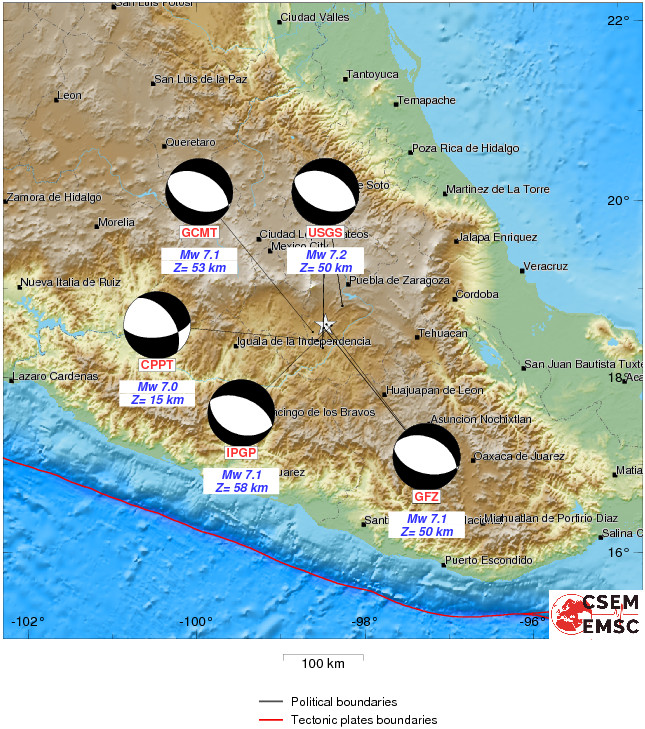

In [10]:
from IPython.core.display import Image, display, HTML

display(Image('https://static2.emsc.eu/Images/EVID/61/619/619258/619258.MT.jpg', width=400))

Use now Obspy to plot the *USGS* solution (add the constraint **source_catalog=USGS** to the previous url):

USGS Solution:


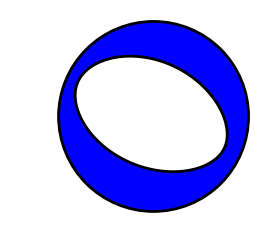

In [11]:
from obspy.imaging.beachball import beachball

url= "http://vigogne.emsc-csem.org/mtws/api/search\
?source_catalog=USGS&eventid=20170919_0000091&format=text"

mt = parsecsv(geturl(url)['content'], usedict=True)[0] #we get a list with only one element.

t = map(float, [mt['mt_mrr'], mt['mt_mtt'], mt['mt_mpp'], mt['mt_mrt'], mt['mt_mrp'], mt['mt_mtp']])
print "USGS Solution:"

beachball(t, width=200);

<a id='sec_04'></a>
## 4. Collect Felt reports (i.e. **Testimonies** ws)
---

Through the EMSC website, mobile and LastQuake app, eyewitnesses are encourage to evaluate the felt intensity for significant earthquakes. All this dataset are available via the **Testimonies** web service.

The search parameters are simple and looks like the other web service specifications. The main difference is found in the output: the only parameters allowed are *format=text* and *format=json*.

In [12]:
url = "http://vigogne.emsc-csem.org/testimonies-ws/api/search?eventid={unid}&format=json"
tdata = parsejson(geturl(url.format(**main_event))['content'])
print tdata

[{u'ev_unid': u'20170919_0000091', u'ev_mag_value': 7.1, u'ev_event_time': u'2017-09-19 18:14:38.5 UTC', u'ev_mag_type': u'mw', u'ev_nbtestimonies': 742, u'ev_depth': 50, u'full_count': 1, u'ev_last_update': u'2017-11-20 02:55:06 UTC', u'ev_region': u'PUEBLA, MEXICO', u'ev_longitude': -98.47, u'ev_deltatime': u'@ 2 mons 8 hours 40 mins 27.5 secs', u'ev_id': 5463, u'ev_latitude': 18.59}]


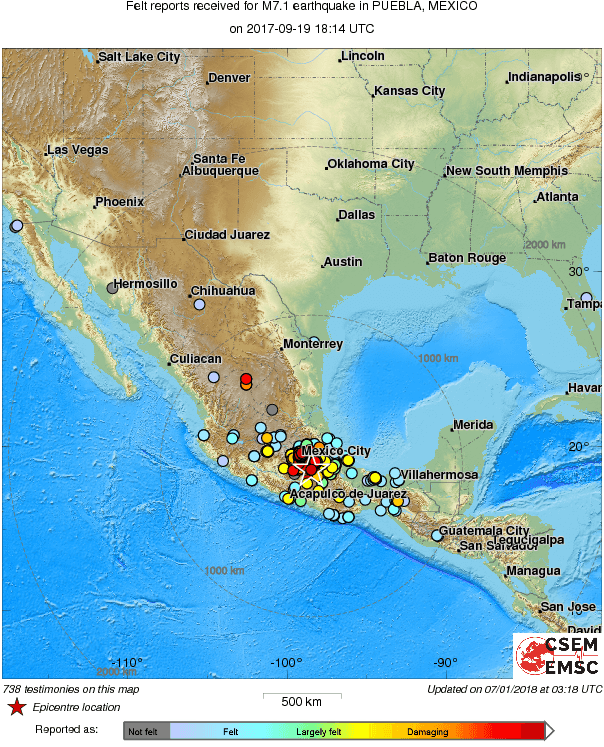

In [13]:
display(Image('https://static2.emsc.eu/Images/INTENSITY_MAPS/61/619258/AUTOMATIC/AreaThreshold_5/EMS_98__RMW_Musson/LocMethod_PerClusterCity/DynamicClusters_MaxSize50/IntensityMapThumbnails.png', width=400))

<a id='sec_05'></a>
## 5. Identify if more informations are available from other seismological institutes (i.e. **EventID** ws)
---
Many institutes associate an identifier to one seismic event. And this identifier is an effective way to find the information.

It can be time consuming to get *ID* of different institutes. The **EventID** web service is intended to facilitate this task.

To illustrate this, we have the *ID* of the Seismic Portal of the *M7.1 Mexican earthquake* 
> unid : 20170919_0000091

And we would like to get the information from the websites of EMSC, USGS and INGV...

In [14]:
#%%capture --no-stdout

url = "http://vigogne.emsc-csem.org/eventid/api/convert?source_id={id}&source_catalog={source}&out_catalog={out}&format=text"
res = geturl(url.format(id=main_event['unid'], source='UNID', out='all'))
iddata = parsecsv(res['content'], usedict=True)

for l in iddata:
    print "\n* Institute {#catalog:5}, ID: {eventid}\n   url: {url}".format(**l)


* Institute EMSC , ID: 619258
   url: http://www.seismicportal.eu/fdsnws/event/1/query?catalog=EMSC-RTS&source_id=619258&format=text

* Institute ISC  , ID: 610994335
   url: http://isc-mirror.iris.washington.edu/fdsnws/event/1/query?eventid=610994335

* Institute USGS , ID: us2000ar20
   url: https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us2000ar20&format=csv

* Institute INGV , ID: 17111031
   url: http://webservices.ingv.it/fdsnws/event/1/query?format=text&eventId=17111031


Now we can check information, data and data products available from: 
 
| Institute | URL                     
| ---       | ---                      
| EMSC      | https://www.emsc-csem.org/Earthquake/earthquake.php?id=619258
| USGS      | https://earthquake.usgs.gov/earthquakes/eventpage/us2000ar20
| INGV      | http://cnt.rm.ingv.it/event/17111031



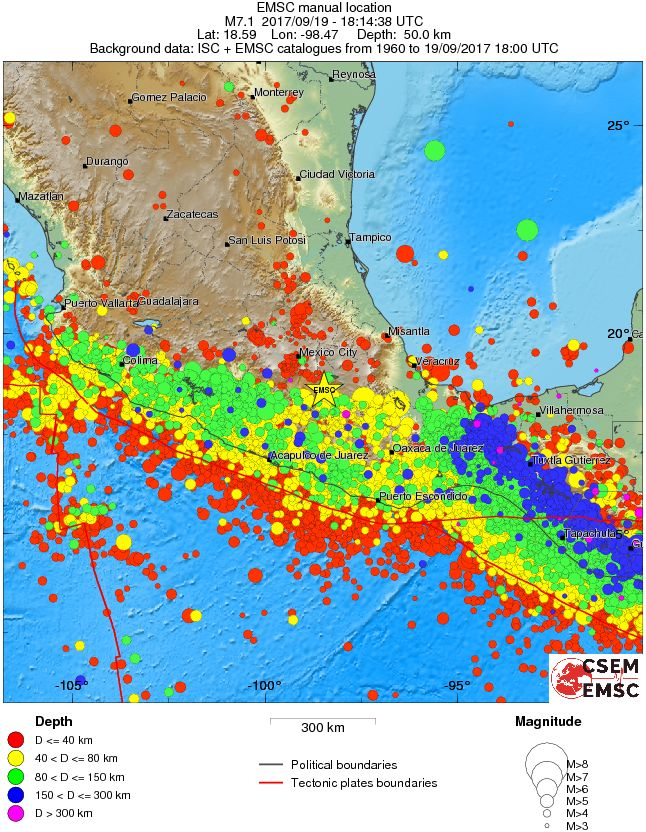

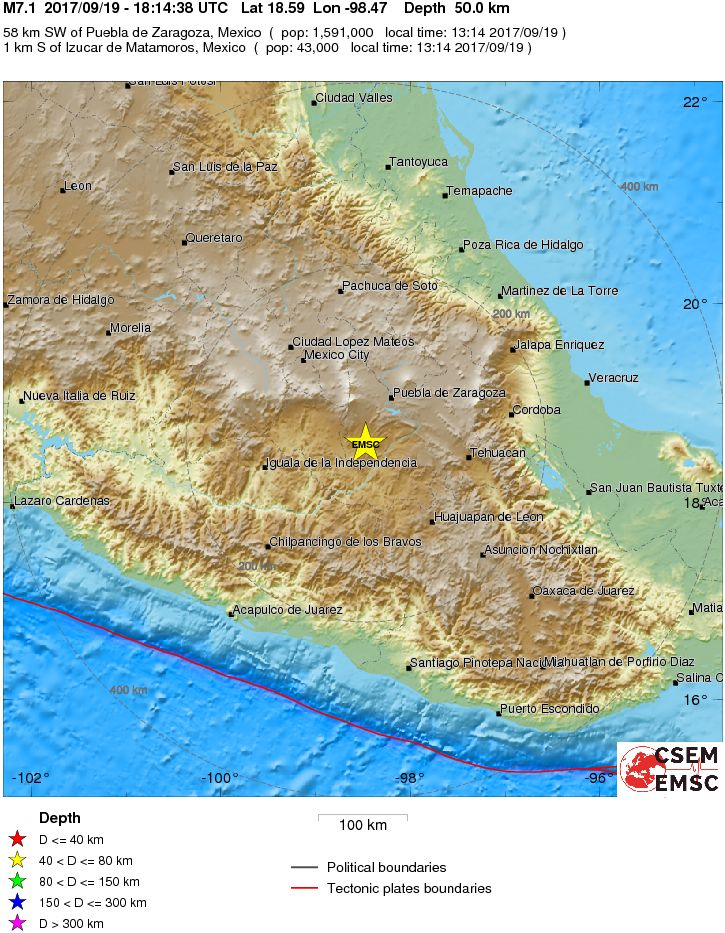

In [15]:
# e.g. EMSC data prodcuts
display(Image('https://static1.emsc.eu/Images/EVID/61/619/619258/619258.wide.seismicity.jpg', width=400))
display(Image('https://static1.emsc.eu/Images/EVID/61/619/619258/619258.regional.jpg', width=400))